In [183]:
import numpy as np
from numpy.linalg import inv
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from collections import OrderedDict
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

# Load the data set and weight for the numbers we
# will identify
dataDict   = scipy.io.loadmat('./data/ex3data1.mat')
weightDict = scipy.io.loadmat('./data/ex3weights.mat')

X = dataDict['X']
y = dataDict['y']

thetaInput1 = weightDict['Theta1']
thetaInput2 = weightDict['Theta2']

# Define number of layers (3) and number of nodes in each layer
s = OrderedDict()
s[1] = X.shape[1] # 20x20 input image (400 nodes in layer 1)
s[2] = 25         # hidden layer (25 nodes in layer 2)
s[3] = 10         # digits from 1 thru 10 (10 nodes in output layer 3)


In [184]:
def randInitialWeights(rows, cols):
    # Define and randomize theta matrices
    # One effective strategy for choosing epsilon is to base it on the number of units in the 
    # network. A good choice of epsilon is (sqrt(6) / sqrt(Lin + Lout)), where Lin = sl 
    # and Lout = sl+1 are the number of units in the layers adjacent to Θ(l).
    epsilon = np.sqrt(6) / np.sqrt(rows + cols)
    return np.random.rand(rows, cols) * 2 * epsilon - epsilon

# Theta at layer 1 is 25 rows (activation output) by 401 input columns
theta1 = randInitialWeights(s[2], s[1]+1)

# Theta at layer 2 is 10 rows (activation output) by 26 input columns
theta2 = randInitialWeights(s[3], s[2]+1)

In [185]:
print("data keys", dataDict.keys())
print("weight keys", weightDict.keys())
print("X shape={0}\ny shape={1}".format(X.shape, y.shape))
print("Theta1 shape={0}\nTheta2 shape={1}".format(theta1.shape, theta2.shape))


data keys dict_keys(['__globals__', 'X', '__header__', 'y', '__version__'])
weight keys dict_keys(['__globals__', 'Theta1', '__header__', 'Theta2', '__version__'])
X shape=(5000, 400)
y shape=(5000, 1)
Theta1 shape=(25, 401)
Theta2 shape=(10, 26)


In [174]:
def DisplayFunc(imageArray, startRow, displayRows, displayCols):
    ''' 
    imageArray  : vectorized rows of m X n image
    startRow    : row to start from in imageArray
    displayRows : number of rows to display on screen
    displayCols : number of columns to display on screen
    '''
    m, n = imageArray.shape

    fig = plt.figure(figsize=(2. * displayCols, 2.26 * displayRows))
    gs = gridspec.GridSpec(displayRows, displayCols, wspace=0.0025, hspace=0.0025)

    ax = [plt.subplot(gs[i]) for i in range(displayRows * displayCols)]
    gs.update(hspace=0)
    gs.tight_layout(fig, pad=0, h_pad=0, w_pad=0)

    for i, im in enumerate(imageArray[startRow:startRow + displayRows * displayCols]):
        vmax = max(im.max(), -im.min())
        ax[i].imshow(im.reshape(20,20), cmap=plt.cm.gray,
                     interpolation='nearest', vmin=-vmax, vmax=vmax)
        ax[i].axis('off')
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].set_aspect('equal')

    plt.show()


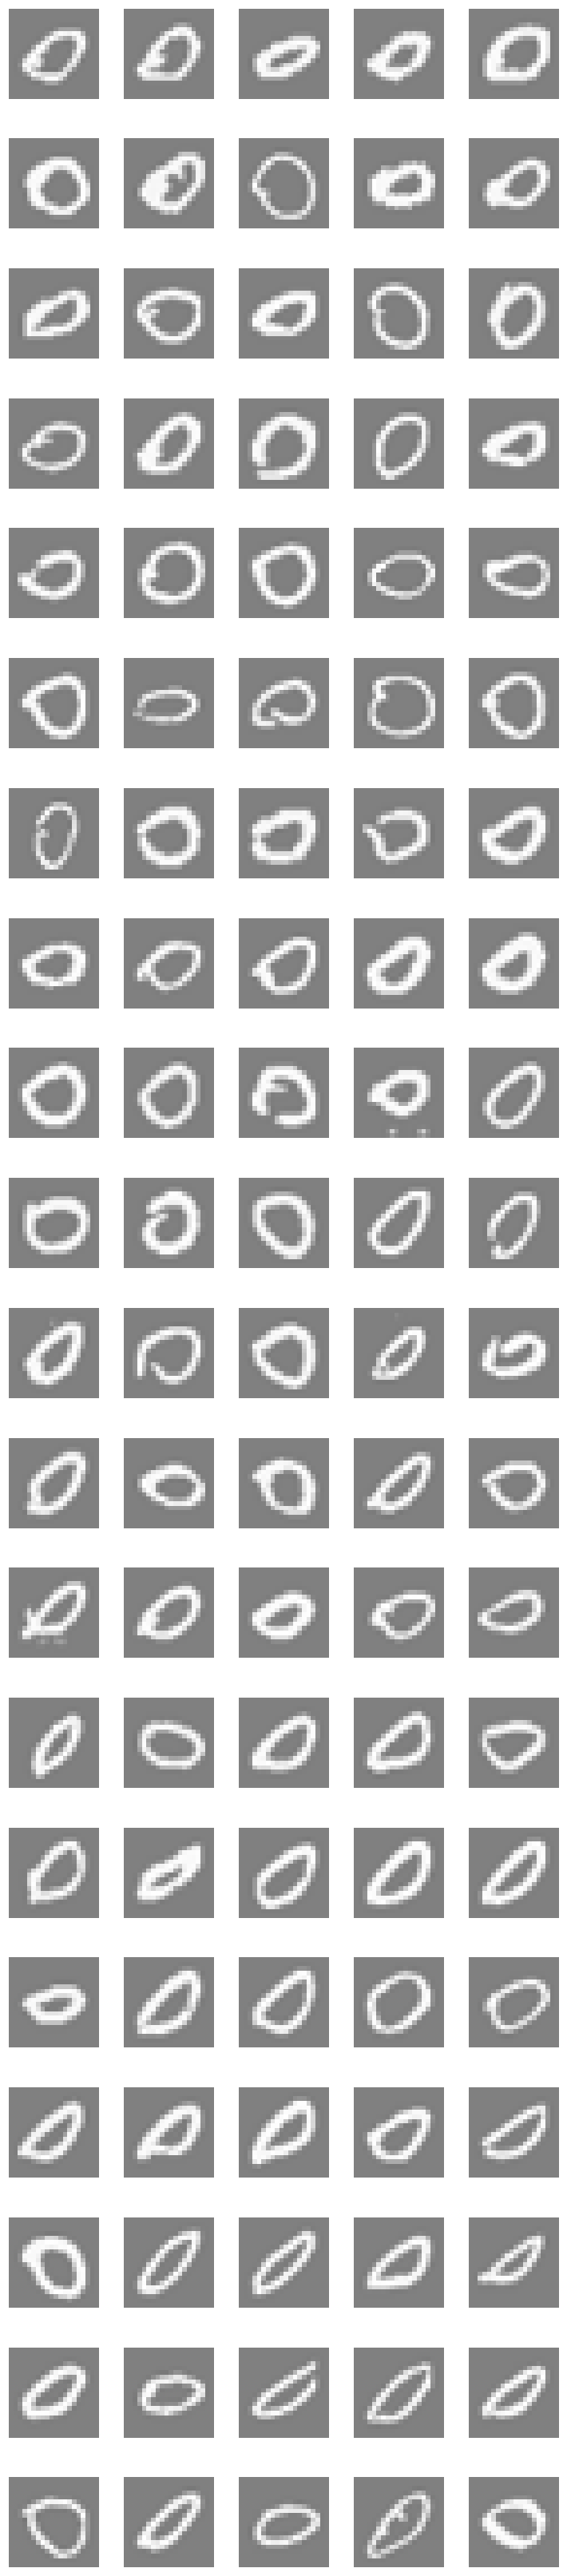

In [186]:
DisplayFunc(X, 0, 20, 5)

In [187]:
class NeuralNet():
    
    def __init__(self, X, y, theta1, theta2, rlambda):
        self._X = X
        self._y = y
        
        # Use the one hot encoder or the alternate method following
        # the encoder
        encoder = OneHotEncoder(sparse=False)
        self._yhot = encoder.fit_transform(y)

        # Each y for every sample turns into a vector with 10 elements
        # equating to the 10 output nodes of the neural network.  If 
        # y == 1 then yhot == [ 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        # y == 2 then yhot == [ 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        # y == 0 then yhot == [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        # etc.
        # Note that the ymod row is still the same index as the
        # equivalent x row sample.
        #
        #self._yhot = np.zeros((y.shape[0], 10)) # most of them are zeros
        #for i, val in enumerate(y):
        #   self._yhot[i][val-1] = 1
            
        self._m        = X.shape[0] # number of samples
        self._theta1   = theta1
        self._theta2   = theta2
        self._rlambda  = rlambda    # regularization lambda (0 for no regularization)
        
    def forwardPropogate(self, xinput):
        
        # At column 0 insert a Ones column =>  a1.shape=(5000, 401)
        a1 = np.insert(xinput, 0, 1, axis=1)
        
        #  (5000 X 401) dot transpose(25 x 401) => z2.shape=(5000, 25)
        z2 = np.dot(a1, self._theta1.T)
        
        a2 = 1 / (1 + np.exp(-z2))
        
        # At column 0 insert a Ones column => a2.shape=(5000, 26)
        a2 = np.insert(a2, 0, 1, axis=1)
        
        # (5000 X 26) dot transpose(10 X 26) => z3.shape=(5000, 10)
        z3 = np.dot(a2, self._theta2.T)
        
        # h.shape = (5000 X 10)
        h = 1 / (1 + np.exp(-z3))
        
        return a1, a2, h
        
    def computeCost(self):        
              
        a1, a2, h = self.forwardPropogate(self._X)
        
        sum = 0
        for i in range(0, self._m):
            
            # (1 X 10) dot transpose(1 X 10) = (1 X 1)
            sum += (-np.dot(    self._yhot[i:i+1], np.transpose(np.log(    h[i:i+1]))) -
                     np.dot(1 - self._yhot[i:i+1], np.transpose(np.log(1 - h[i:i+1]))))
        
        sum  = sum / self._m
        sum += self._rlambda / (2 * self._m) * (np.sum(np.square(self._theta1[:][1:])) + 
                                                np.sum(np.square(self._theta2[:][1:])))
        return sum
    
    # end of computeCost

    def gradientDescent(self, alpha, iters):
        
        # how many thetas are we computing. Theta is
        # a column vector
        ntheta = self._theta.shape[0]
        
        cost = np.zeros(iters)
        
        # for maximum number of gradient descent
        # iterations
        for ndescent in range(iters):
            
            # hypothesis is:
            #   h_theta(x) = g(theta(0) * x(0) + theta(1) * x(1) + ... + theta(n) * x(n))
            #
            # g is the sigmoid function:
            #   g(z) = 1 / (1 + exp(-z))
            #
            inner = np.dot(self._X, self._theta)
            
            # This is the sigmoid function giving us values between 0 and 1
            h_theta_x = 1 / (1 + np.exp(-inner))
                 
            n1 = h_theta_x - self._y
                        
            # _X of 5000 samples would be (5000 x 1))
            n2 = np.dot(np.transpose(self._X[:,0:1]), n1)
            
            n3 = alpha * (1 / self._m) * n2
            self._theta[0] = self._theta[0] - n3
            #print("shape n1=", n1.shape, "n2=", n2.shape, "n3=", n3.shape)
          
            # _X of 5000 samples and 20 features would be (5000 x (20 - 1))
            n2 = np.dot(np.transpose(self._X[:,1:]), n1)
            
            n3 = alpha * ((1 / self._m) * n2 + (self._rlambda / self._m) * self._theta[1:])
            self._theta[1:] = self._theta[1:] - n3
            #print("shape n1=", n1.shape, "n2=", n2.shape, "n3=", n3.shape)
            
            cost[ndescent] = self.computeCost()
        # end for ndescent

        return self._theta, cost
    # end gradientDescent

In [188]:
m = X.shape[0]
errCount = 0
alpha    = 0.001
rlambda  = 1.0

# compute cost with no regularization
cost = NeuralNet(X, y, thetaInput1, thetaInput2, 0).computeCost()
print("lambda=", 0, "cost=", cost)

# compute cost with regularization
cost = NeuralNet(X, y, thetaInput1, thetaInput2, rlambda).computeCost()
print("lambda=", rlambda, "cost=", cost)

# Now start using our unlearned thetas
gd = NeuralNet(X, y, thetaInput1, thetaInput2, rlambda)

# Now lets check out our prediction versus actual
a1, a2, h = gd.forwardPropogate(X)

# Python arrays are indexed by zero so
# we'll need to add 1 for comparison to y
for i in range(0, m):
    imax = np.where(h[i] == h[i].max())
    if y[i] != imax[0]+1:
        errCount += 1
        
print("Samples=", m, "Prediction errors=", errCount, "Success rate=", (m-errCount)/m)

lambda= 0 cost= [[ 0.28762917]]
lambda= 1.0 cost= [[ 0.3790464]]
Samples= 5000 Prediction errors= 124 Success rate= 0.9752
